# Clustering in Real World

## Dominant colors in images

All images consist of pixels. Each pixel has three values: Red, Green and Blue. Comibination of these RGB values froms the actual color of the pixel. To finde dominant colors, Kmeans clustering can be performed on the RGB components.
While doing it their position won't matter.

### Extract RGB values from image

In [10]:
from matplotlib import image as img
batman_image = img.imread("batman.jpg")
print(batman_image.shape)
r=[]
g=[]
b=[]
for i in batman_image:
    for temp_r, temp_g, temp_b in i:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

(169, 269, 3)


### How many dominant colors?

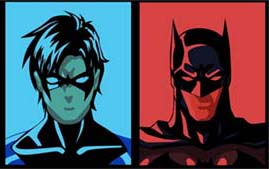

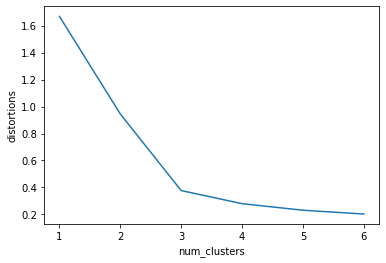

In [22]:
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import whiten
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
batman_df = pd.DataFrame({"red":r, "blue":b,"green":g,"scaled_red":whiten(r),
                         "scaled_blue":whiten(b),"scaled_green":whiten(g)})

distortions = []
num_clusters = range(1,7)

for i in num_clusters:
    cluster_centers, distortion = kmeans(batman_df[["scaled_red","scaled_blue","scaled_green"]],i)
    distortions.append(distortion)
    
elbow_plot = pd.DataFrame({"num_clusters":num_clusters, "distortions":distortions})
sns.lineplot(x="num_clusters", y="distortions", data=elbow_plot)
plt.show()

There are three distinct colors present in the image.

### Display dominant colors

To display the dominant colors, convert the colors of the cluster centers to their raw values.

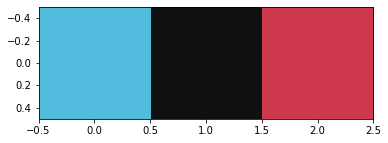

In [28]:
cluster_centers, distortion = kmeans(batman_df[["scaled_red","scaled_blue","scaled_green"]],3)
r_std, g_std, b_std = batman_df[["red", "green", "blue"]].std()

colors = []
for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    colors.append((scaled_r * r_std / 255,
                  scaled_g * g_std / 255,
                  scaled_b * b_std / 255))
plt.imshow([colors])
plt.show()

## Document clustering

Document clustering uses some concepts from NLP. TF-IDF is a weighted statistic that describes the importance of a term in a document.

The text itself can't analyzed before converting into smaller parts called tokens.

TF-IDF creates sparse matrix which kmeans doesn't support so to conver it .todense() is used.

Each value in the cluster center is the importance of terms.

### TF-IDF of movie plots

In [63]:
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words("English")
def remove_noise(text, stop_words = stopwords.words("English")):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub("[^A-Za-z0-9]+","", token)
        if len(token) > 1 and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens


movies = pd.read_csv("movies_plot.csv")
plots = list(movies[0:250]["Plot"])

tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=0.1, max_features=50,
                                   tokenizer=remove_noise)
tfidf_martix = tfidf_vectorizer.fit_transform(plots)

### Top terms in movie clusters

In [126]:
num_cluesters = 2
cluster_centers, distortion = kmeans(tfidf_martix.todense(), num_cluesters)
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_cluesters):
    center_terms = dict(zip(terms, cluster_centers[i]))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:4])

['man', 'police', 'wife', 'killed']
['back', 'father', 'one', 'money']


Notice positive, warm words in the second cluster and words referring to action in the first cluster.

### Clustering with multiple features

Check how the cluster centers vary with respect to the overall data. If cluster centers of some features do not vary significantly it is an indication that you can drop that feature in the next run.

If one or more clusters are significantly smaller that the rest, their cluster centers can be similar to others if it is cluster number can be reduced.

Creating bar chart to see how variables vary across clusters.

When dealing with a larg number of features certain  techniques of reduction may be used. Factor analysis and Multidimensional scaling.

### Basic checks on clusters

In [147]:
from scipy.cluster.vq import vq

fifa = pd.read_csv("fifa_18_sample_data.csv")
fifa = fifa[0:250]
fifa["scaled_pac"] = whiten(fifa["pac"]).round(2)
fifa["scaled_dri"] = whiten(fifa["dri"]).round(2)
fifa["scaled_sho"] = whiten(fifa["sho"]).round(2)
    
cluster_centers, distortion = kmeans(fifa[["scaled_pac","scaled_dri","scaled_sho"]],3)
fifa["cluster_labels"], distortion_list = vq(fifa[["scaled_pac","scaled_dri","scaled_sho"]], cluster_centers)
print(fifa.groupby("cluster_labels")["ID"].count())
print(fifa.groupby("cluster_labels")["eur_wage"].mean())

cluster_labels
0     83
1     61
2    106
Name: ID, dtype: int64
cluster_labels
0    132120.481928
1    115950.819672
2    131358.490566
Name: eur_wage, dtype: float64


The cluster sizes are not very different, and there are no significant differences that can be seen in the wages. Further analysis is required to validate these clusters.

                scaled_pac  scaled_sho  scaled_pas  scaled_dri  scaled_def  \
cluster_labels                                                               
0                 5.432464    3.660143    7.160464    6.751964    3.971071   
1                 6.685181    5.424139    8.455528    8.511875    2.508819   

                scaled_phy  
cluster_labels              
0                 9.208857  
1                 8.339653  


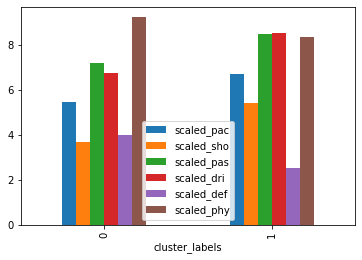

1 ['Cristiano Ronaldo' 'L. Messi' 'Neymar' 'L. Suárez' 'M. Neuer']
0 ['Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng' 'D. Godín']


In [173]:
fifa = pd.read_csv("fifa_18_sample_data.csv")

fifa["scaled_pac"] = whiten(fifa["pac"]).round(2)
fifa["scaled_dri"] = whiten(fifa["dri"]).round(2)
fifa["scaled_sho"] = whiten(fifa["sho"]).round(2)
fifa["scaled_pas"] = whiten(fifa["pas"]).round(2)
fifa["scaled_def"] = whiten(fifa["def"]).round(2)
fifa["scaled_phy"] = whiten(fifa["phy"]).round(2)

scaled_features = ['scaled_pac',
 'scaled_sho',
 'scaled_pas',
 'scaled_dri',
 'scaled_def',
 'scaled_phy']

cluster_centers, _ = kmeans(fifa[scaled_features], 2)
fifa["cluster_labels"], _ = vq(fifa[scaled_features], cluster_centers)
print(fifa.groupby("cluster_labels")[scaled_features].mean())

fifa.groupby("cluster_labels")[scaled_features].mean().plot(legend=True, kind="bar")
plt.show()

for cluster in fifa["cluster_labels"].unique():
    print(cluster, fifa[fifa["cluster_labels"] == cluster]["name"].values[:5])

One of the clusters primarily represents attackers, whereas the other represents defenders. Surprisingly, a top goalkeeper Manuel Neuer is seen in the attackers group, but he is known for going out of the box and participating in open play, which are reflected in his FIFA 18 attributes.

